In [3]:
"""
Pipeline
"""
import os
import torch
import pandas as pd
from pathlib import Path
import flexynesis as flx
from pandas import DataFrame
from typing import Dict, List
import matplotlib.pyplot as plt

Seed set to 42


In [4]:
# Define the analysis folders
DIRECTEDPRED = "analysis_fl/DirectPred/"
SUPERVISED_VAE = "analysis_fl/supervised_vae/"

In [5]:
def preprocessing_results(dir_directpred: Path, dir_supervised_vae: Path)-> Dict[str, List[float]]:
        """
        Preprocess the results of the analysis by adding them in dictionaries
        """
        # Create dictionaries
        direct_pred: Dict[str, List] = {
            "mutcnv_early": [],
            "mutcnv_intermediate": [],
            "mutrna_early": [],
            "mutrna_intermediate": [],
            "mut_early": [],
            "mut_intermediate": [],
        }
        supervised_vae: Dict[str, List] = {
            "mutcnv_early": [],
            "mutcnv_intermediate": [],
            "mutrna_early": [],
            "mutrna_intermediate": [],
            "mut_early": [],
            "mut_intermediate": [],
        }

        # Define empty lists
        direct_pred_list = []
        supervised_vae_list = []

        # Read the files with stats and append pearson corr values based on file_names
        for file_name in os.listdir(dir_directpred):
            # print(file_name)
            if file_name.endswith("stats.csv"):
                # Read the file
                df = pd.read_csv(os.path.join(dir_directpred, file_name))
                # Define the value of pearson in df
                pears_cor_value = float(df.loc[df["metric"] == "pearson_corr", "value"].values[0])
                # Add pearson corr values to the list
                direct_pred_list.append(pears_cor_value)
            
        # Ensure number of values matches dictionary keys
        if len(direct_pred_list) == len(direct_pred.keys()):
            # Assign values correctly
            for key, value in zip(direct_pred.keys(), direct_pred_list):
                direct_pred[key].append(value)
        else:
            print("Error: Mismatch between number of values and dictionary keys")


        for file_name_2 in os.listdir(dir_supervised_vae):
            if file_name_2.endswith("stats.csv"):
                # Read the file
                df = pd.read_csv(os.path.join(dir_supervised_vae, file_name_2))
                # Define the value of pearson in df
                pears_cor_value = float(df.loc[df["metric"] == "pearson_corr", "value"].values[0])
                # Add pearson corr values to the list
                supervised_vae_list.append(pears_cor_value)
        # Ensure number of values matches dictionary keys
        if len(supervised_vae_list) == len(supervised_vae.keys()):
            # Assign values correctly
            for key, value in zip(supervised_vae.keys(), supervised_vae_list):
                supervised_vae[key].append(value)
        else:
            print("Error: Mismatch between number of values and dictionary keys")
    
        # Print the dictionaries
        print(f"DiretctPred dictionary:\n {direct_pred}\n\n")
        print(f"Supervised vae dictionary:\n {supervised_vae}\n\n")

        # Return dictionaries
        return direct_pred, supervised_vae

In [6]:
def plots(direct_pred: Dict[str, List[float]], supervised_vae: Dict[str, List[float]]):
        """
        Plots the results of the direct prediction and supervised VAE.
        """
        # Convert dictionaries into a DataFrame
        df_direct = pd.DataFrame(direct_pred).T.rename(columns={0: 'DirectPred'})
        df_vae = pd.DataFrame(supervised_vae).T.rename(columns={0: 'SupervisedVAE'})

        # Merge data into one DataFrame
        df = df_direct.merge(df_vae, left_index=True, right_index=True)

        # Sort based on best performance in either method
        df["Best Score"] = df.max(axis=1)
        df_sorted = df.sort_values(by="Best Score", ascending=False).drop(columns=["Best Score"])

        # Create a bar plot
        plt.figure(figsize=(10, 6))
        df_sorted.plot(kind="bar", figsize=(10, 6), width=0.7, colormap="coolwarm", edgecolor="black")

        # Title and labels
        plt.title("Ranking of Experiments Based on Pearson Correlation", fontsize=14, fontweight="bold")
        plt.ylabel("Pearson Correlation", fontsize=12)
        plt.xlabel("Experiment (data types)", fontsize=12)
        plt.xticks(rotation=45, ha="right")

        # Add grid and legend
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.legend(title="Method", fontsize=11)

        # Show plot
        plt.tight_layout()
        if not os.path.exists("plots"):
            os.makedirs("plots")
        plt.savefig("plots/ranking_of_experiments.png", dpi=300)
        plt.show()


DiretctPred dictionary:
 {'mutcnv_early': [0.1213546362513042], 'mutcnv_intermediate': [0.1614323801357784], 'mutrna_early': [0.3760482943480843], 'mutrna_intermediate': [0.3719056634754209], 'mut_early': [-0.0464905075394305], 'mut_intermediate': [0.101773445961184]}


Supervised vae dictionary:
 {'mutcnv_early': [0.1794371180968926], 'mutcnv_intermediate': [0.2780059421356757], 'mutrna_early': [0.3416627477151873], 'mutrna_intermediate': [0.3653923042832111], 'mut_early': [0.0393509938613475], 'mut_intermediate': [0.0023357512179908]}




<Figure size 1000x600 with 0 Axes>

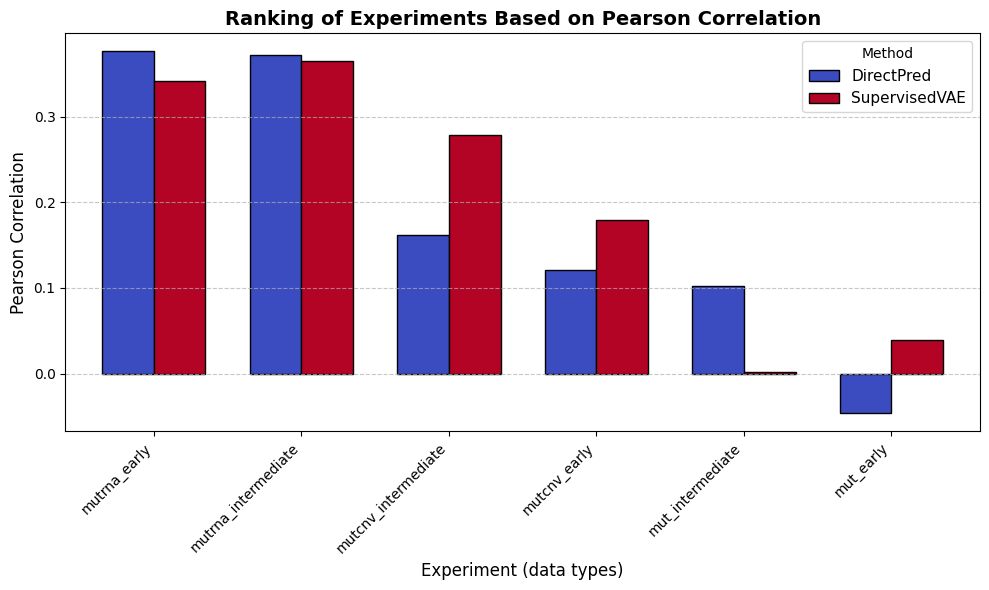

In [7]:
# Define the functions above
direct_pred, supervised_vae = preprocessing_results(dir_directpred=DIRECTEDPRED, dir_supervised_vae=SUPERVISED_VAE)
# Plot the results
plots(direct_pred=direct_pred, supervised_vae=supervised_vae)

##### 4a) Base on the plot above, I think that the best model is the DirectPred with the early fusion in mut-rna data.

##### 4b) Explore the train/test embeddings from the best model (from 4a).

In [8]:
# Load embeddings
train_embeddings = pd.read_csv("analysis_fl/DirectPred/DirectPred_mutrna_early.embeddings_train.csv", sep=",")
test_embeddings = pd.read_csv("analysis_fl/DirectPred/DirectPred_mutrna_early.embeddings_test.csv", sep=",")

clinical_data = pd.read_csv("ccle_vs_gdsc/test/clin.csv", sep=",")
print(clinical_data["tissueid"].unique())
# # Load the model
final_model = torch.load("analysis_fl/DirectPred/DirectPred_mutrna_early.final_model.pth", weights_only=False)


['Lung' 'Prostate' 'Esophagus/Stomach' 'Lymphoid' 'CNS/Brain' 'Skin'
 'Bladder/Urinary Tract' 'Kidney' 'Thyroid' 'Soft Tissue' 'Head and Neck'
 'Other' 'Bone' 'Ovary/Fallopian Tube' 'Peripheral Nervous System'
 'Myeloid' 'Uterus' 'Breast' 'Pancreas' 'Cervix' 'Bowel' 'Vulva/Vagina'
 'Biliary Tract' 'Liver' 'Pleura' 'Testis' 'Gestational' 'Adrenal Gland'
 'Eye']


In [9]:
# Define the data from test-embendings
data_tr = train_embeddings.iloc[:, 1:].values  
data_te = test_embeddings.iloc[:, 1:].values
# Extracting the labels 
labels_tr = train_embeddings.iloc[:, 0].values
labels_te = test_embeddings.iloc[:, 0].values

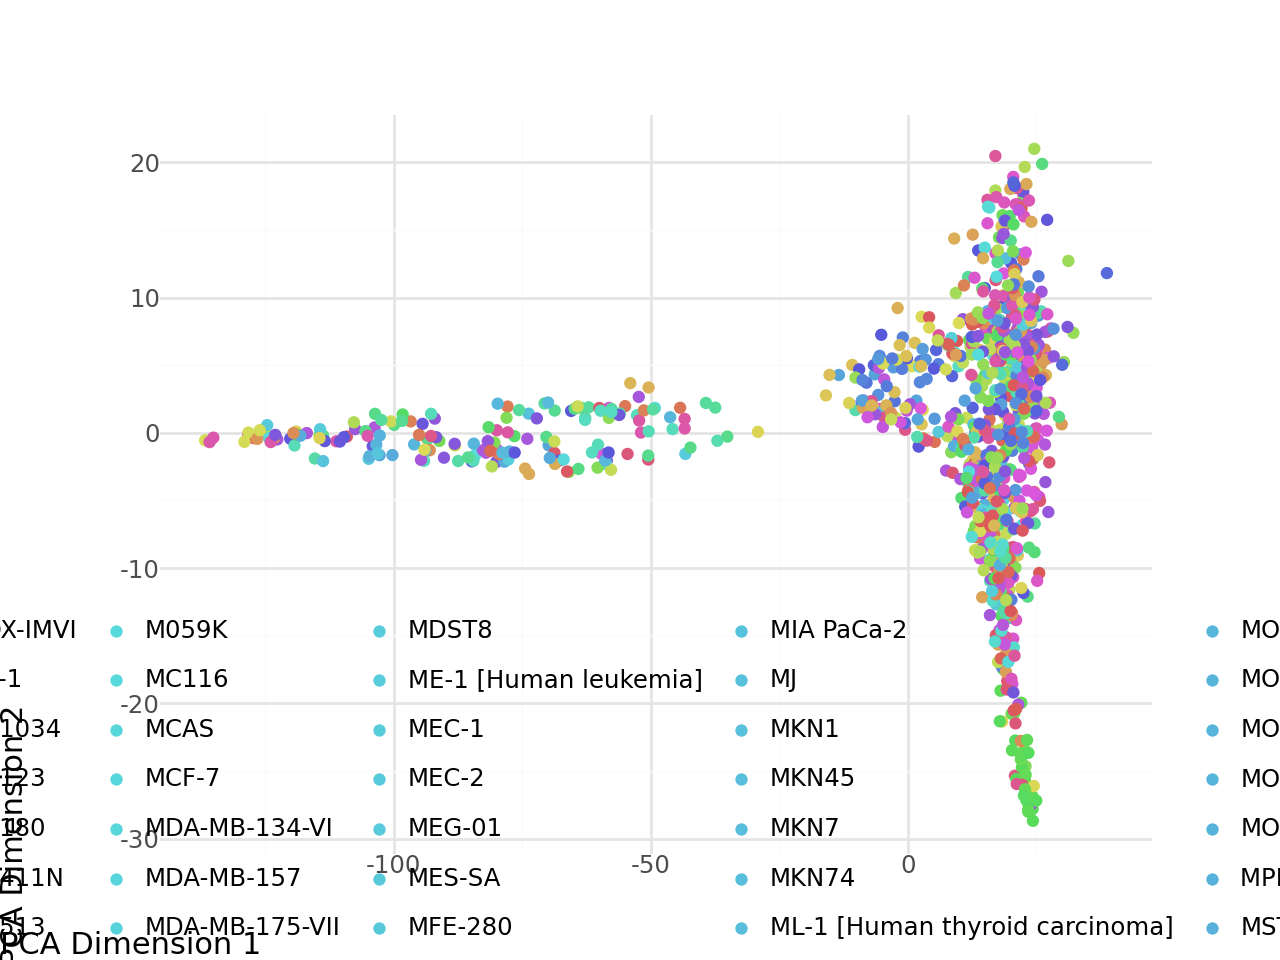

In [10]:
# Applying PCA and plotting with flexynesis
flx.plot_dim_reduced(data_tr, labels_tr, color_type="categorical")

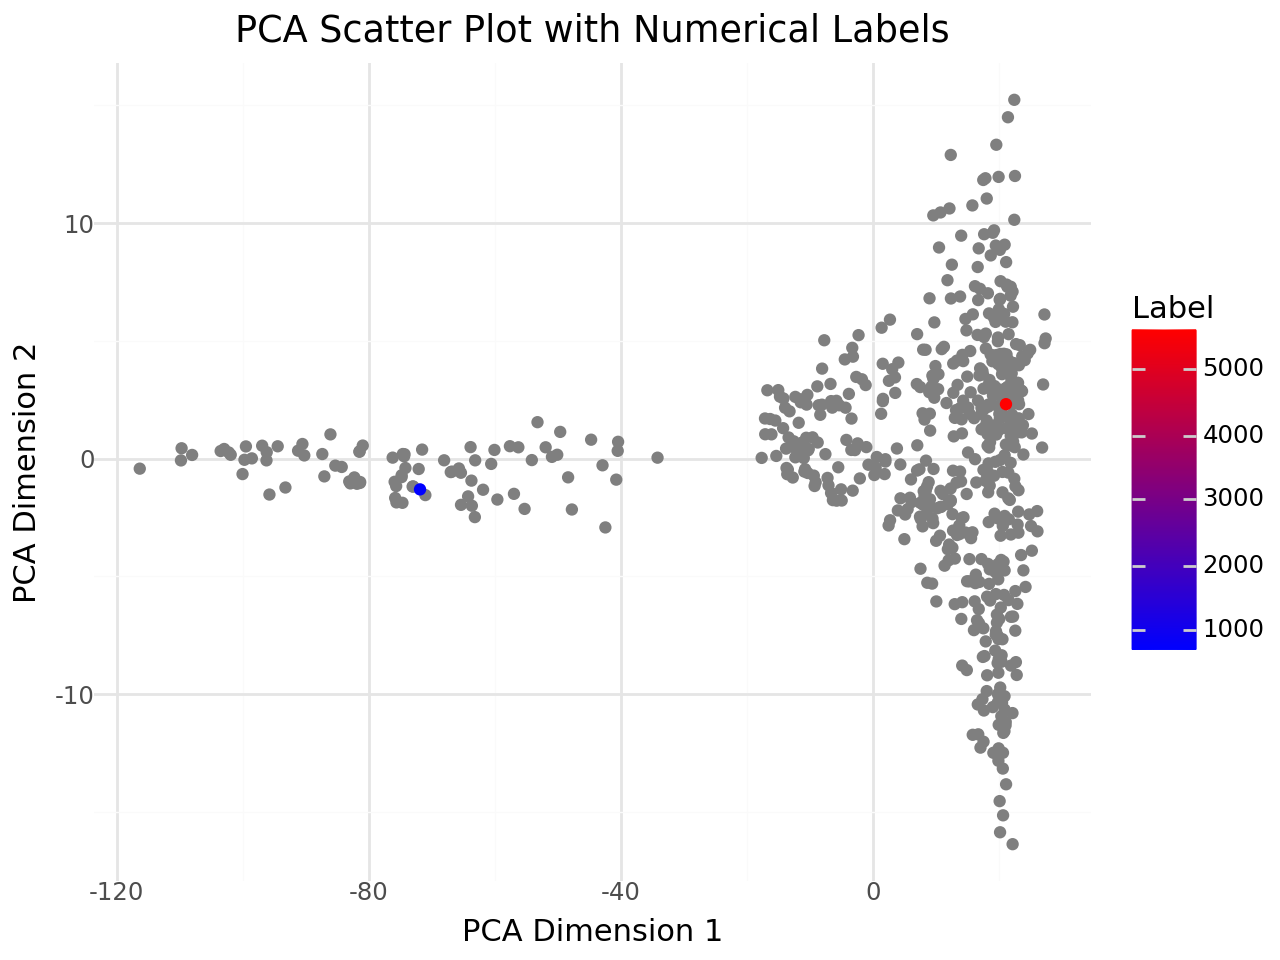

In [11]:
flx.plot_dim_reduced(data_te, labels_te, color_type="numerical")

##### 4c) Import the feature importance scores from the best model (from 4a).Get top 10 markers. Do literature search. Are any of the top markers associated to “Erlotinib”? 

In [12]:
featur_impor_dataset = pd.read_csv("analysis_fl/DirectPred/DirectPred_mutrna_early.feature_importance.IntegratedGradients.csv", sep=",")

# print(featur_impor_dataset)
importance_col = featur_impor_dataset["importance"]

# Sort the DataFrame by the 'importance' column in descending order
sorted_data = featur_impor_dataset.sort_values('importance', ascending=False)

# print(sorted_data)
sorted_data_10 = sorted_data[:10]
print(sorted_data_10)

# Print the most important features (top rows)
# print(sorted_data.head())

     target_variable  target_class  target_class_label layer      name  \
1134       Erlotinib             0                 NaN   all       XDH   
2          Erlotinib             0                 NaN   all      KRAS   
135        Erlotinib             0                 NaN   all      EGFR   
515        Erlotinib             0                 NaN   all     CXADR   
231        Erlotinib             0                 NaN   all     HNF1B   
1098       Erlotinib             0                 NaN   all     MMP14   
894        Erlotinib             0                 NaN   all    ADAM12   
528        Erlotinib             0                 NaN   all      MPDZ   
190        Erlotinib             0                 NaN   all  SERPINE1   
540        Erlotinib             0                 NaN   all     ACSL5   

      importance            explainer  
1134    0.000977  IntegratedGradients  
2       0.000959  IntegratedGradients  
135     0.000856  IntegratedGradients  
515     0.000732  Integra

In [13]:
# Print the 10 first names of genes based on sorted importance column
print(sorted_data_10["name"])

1134         XDH
2           KRAS
135         EGFR
515        CXADR
231        HNF1B
1098       MMP14
894       ADAM12
528         MPDZ
190     SERPINE1
540        ACSL5
Name: name, dtype: object


##### Get top 10 markers. Do literature search. Are any of the top markers associated to Erlotinib?  

1)  https://pmc.ncbi.nlm.nih.gov/articles/PMC6670022/ 
2)  https://pmc.ncbi.nlm.nih.gov/articles/PMC11078142/ --> KRAS
3)  https://pmc.ncbi.nlm.nih.gov/articles/PMC10453612/ --> EGFR


KRAS and EGFR are associated with Erlotinib.


